In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, center_of_mass
from PIL import Image
from pathlib import Path

In [107]:
def cfinder(filepath, min_size = 5, min_sum = 0, thresh = None):
    '''

    get all the clusters in a tif file

    Parameters
    ------------
    filepath = path on the eos to the picture file
    min_size = 5 the minimum size a cluster has to be
    min_sum = 0 the minimum sum of the elements in a cluster
    thresh = None the value a pixel need for it to be considered part of a cluster
        if thresh == None, thresh is set to the average + 3* the standard deviation of the matrix of the picture
        
    Pedestal file for CMOS tracker: /eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873546.147.ped.tif

    Returns
    ------------
    df = dataframe with the columns:
        cluster = matrix which contains the cluster shape
        pos = position of upper left element of the cluster shape in the matrix of the file
        size = number of elements in the cluster
        sum = sum of elements in the cluster

    '''
    mat = np.array(Image.open(Path(filepath)))
    thresh = thresh if thresh != None else (np.average(mat) + 3 * np.std(mat))
    mat[mat<=thresh] = 0
    
    ped_clus_pos = [[113, 2401], [125, 1058], [232, 716], [263, 2205], [264, 1435], [318, 1821], [453, 1631], [512, 209], [539, 1986], [545, 2429], [587, 1293], [626, 743], [804, 489], [945, 2079], [953, 2437], [1153, 2388], [1156, 122], [1160, 1621], [1170, 2026], [1192, 1323], [1214, 1985], [1251, 697], [1252, 1249], [1281, 1223], [1312, 1871], [1323, 1374], [1327, 107], [1546, 1426], [1553, 1717], [1574, 72], [1608, 2204], [1624, 1409], [1628, 1170], [1673, 1099], [1674, 2270], [1687, 658], [1763, 1307], [1764, 1632], [1880, 147], [1918, 1977], [2036, 1998]]
    for i in ped_clus_pos:
        mat[i[0],i[1]] = 0

    clus = []
    pos = []
    size = []
    tot = []

    struc = np.array([[1,1,1],[1,1,1],[1,1,1]]) * 0.1
    mat_labeled, num = label(mat, structure = struc)
    clust_slices = find_objects(mat_labeled)

    for i in range(num):
        temp_clus = mat[clust_slices[i]]
        temp_lab = mat_labeled[clust_slices[i]].tolist()
        temp_lab = [[val if val == i + 1 else 0 for val in bal] for bal in temp_lab]
        temp_size = len([val for bal in temp_lab for val in bal if val == i + 1])
        temp_tot = sum(sum(temp_clus))
        if temp_size >= min_size and temp_tot >= min_sum:
            size += [int(temp_size)]
            clus += [temp_clus.tolist()]
            pos += [[clust_slices[i][0].start, clust_slices[i][1].start]]
            tot += [temp_tot]

    df = pd.DataFrame([clus,pos,size,tot], index = ['cluster', 'pos', 'size', 'sum']).transpose()

    return df

In [108]:
pedf = '/eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873546.147.ped.tif'
nf = '/eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873349.625.tif'

ped_cl = cfinder(pedf, min_size = 1, min_sum = 0, thresh = 220)
n_cl = cfinder(nf, min_size = 1, min_sum = 0, thresh = 200)

parr = np.array(Image.open(pedf))
narr = np.array(Image.open(nf))

In [106]:
len(n_cl)

281

In [109]:
len(n_cl)

242

In [52]:
np.average(parr), np.std(parr), np.average(narr), np.std(narr)

(10.386380264182495, 4.196929450567018, 10.621896182789522, 22.81116964487355)

In [54]:
max([val for bal in parr for val in bal]), max([val for bal in narr for val in bal])

(4094, 4094)

In [56]:
np.argmax([val for bal in parr for val in bal])/len(parr[0])

1252.5102124183006

In [58]:
np.argmax(parr[1252])

1249

In [90]:
len([val for bal in parr for val in bal])

(5013504, 41)

In [87]:
int(ped_cl.iloc[0]['size']) + int(ped_cl.iloc[1]['size'])

2

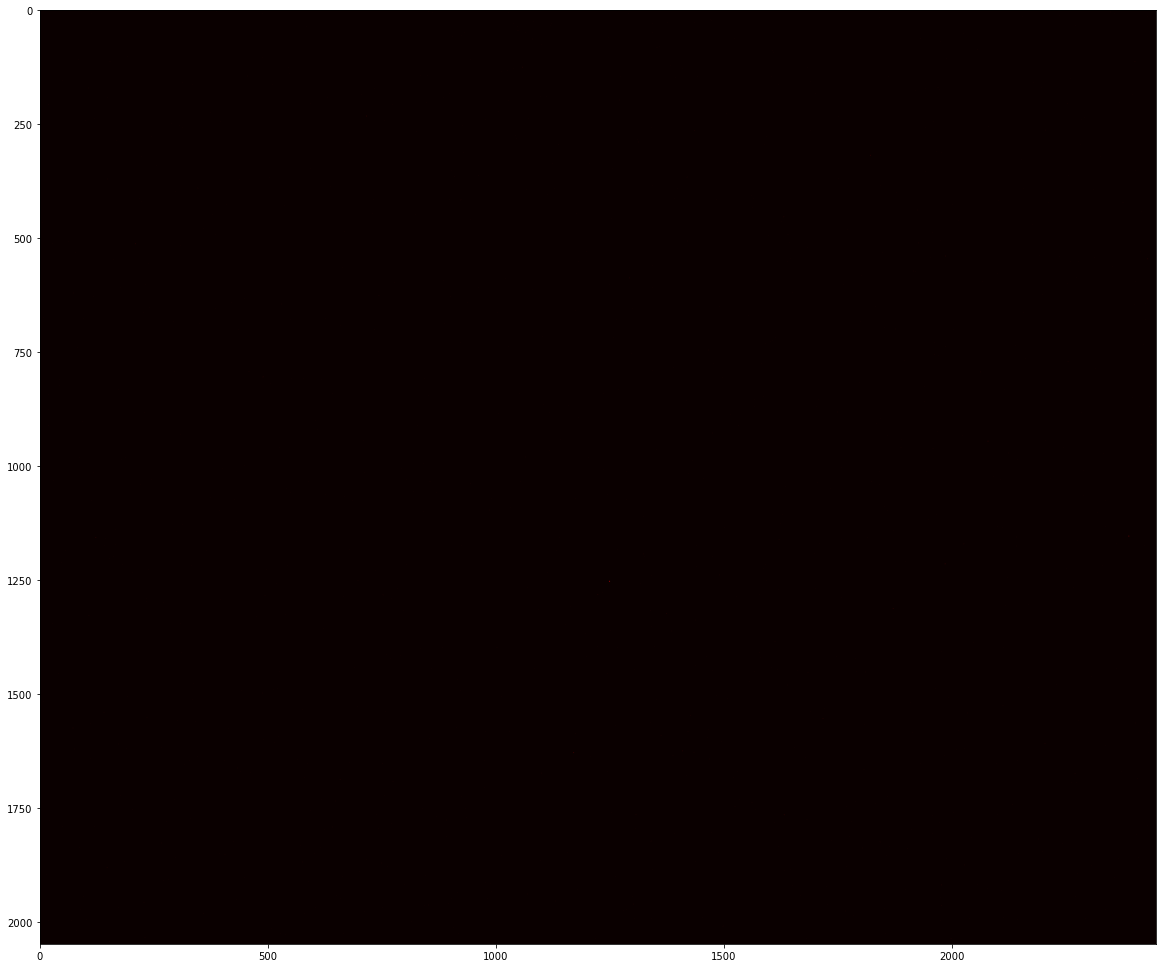

In [36]:
Im = Image.open('/eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873546.147.ped.tif')
arr = np.array(Im)
fig = plt.figure(figsize = (20,20))
plt.imshow(arr, cmap = 'hot')

In [38]:
np.average(arr), np.std(arr)

4.196929450567018

In [65]:
tst = cfinder('/eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873349.625.tif', min_size = 1, thresh = 220)
tstarr = np.array(Image.open('/eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873349.625.tif'))

In [103]:
narr

array([[20,  1,  1, ..., 15,  1,  1],
       [18,  5, 28, ..., 12,  3,  1],
       [12,  1,  5, ...,  8, 16,  5],
       ...,
       [31,  1,  1, ..., 11,  1, 25],
       [18, 11, 22, ..., 20,  1, 16],
       [ 1, 18, 28, ..., 17, 18,  1]], dtype=uint16)

In [92]:
for i in range(len(ped_cl)):
    temp_val = narr[ped_cl.pos[i][0], ped_cl.pos[i][1]]
    print(temp_val, temp_val - ped_cl.iloc[i]['sum'])

219 -8
332 -13
796 12
208 -18
235 9
999 244
451 56
460 -11
654 179
286 -79
536 74
275 -3
302 -81
527 -19
438 -40
2504 550
702 46
172 -75
337 -2
322 100
841 75
264 25
4094 0
421 19
679 94
331 20
266 35
348 74
361 -56
282 44
268 -41
413 2
965 -54
299 28
249 14
233 -17
271 -69
504 -20
200 -44
443 66
340 6


In [75]:
list(ped_cl.pos)

[[113, 2401],
 [125, 1058],
 [232, 716],
 [263, 2205],
 [264, 1435],
 [318, 1821],
 [453, 1631],
 [512, 209],
 [539, 1986],
 [545, 2429],
 [587, 1293],
 [626, 743],
 [804, 489],
 [945, 2079],
 [953, 2437],
 [1153, 2388],
 [1156, 122],
 [1160, 1621],
 [1170, 2026],
 [1192, 1323],
 [1214, 1985],
 [1251, 697],
 [1252, 1249],
 [1281, 1223],
 [1312, 1871],
 [1323, 1374],
 [1327, 107],
 [1546, 1426],
 [1553, 1717],
 [1574, 72],
 [1608, 2204],
 [1624, 1409],
 [1628, 1170],
 [1673, 1099],
 [1674, 2270],
 [1687, 658],
 [1763, 1307],
 [1764, 1632],
 [1880, 147],
 [1918, 1977],
 [2036, 1998]]